# Juliaで流体シミュレーション　①移流方程式の写経
## はじめに
数値流体力学やってみたいけど、ハードル高いしPythonおそいしなーとか思っている中で以下のような記事を見かけました。

- 【Python】流体シミュレーション：移流方程式を実装する
https://qiita.com/KQTS/items/354c85adb7d46e28e8da

- 1次元シュレーディンガー方程式を有限要素法で解いてみる in Julia
https://qiita.com/cometscome_phys/items/fbeaa92fcb4b6d8c6240

Juliaで書いたらそれっぽいコードでもそれなりに早く動くのでは？  
ということで、自分の知識には数値流体力学もPythonもJuliaも、何ならMarkdownも微分方程式もまったくわかってないけど、とりあえずやってみようという記事です。


とりあえずの目標はPythonでやってるやつをJuliaで動かしてみて、Pythonのコード（高速化は全然されていない）と速度比較や書きやすさ比較してみようというものです。@KQTSさんのコードそのままうつしてます。ありがとうございます！（勝手に使ってごめんなさい）


Juliaの操作は


- Juliaで最低限やっていくための配列操作まとめ  
https://qiita.com/A03ki/items/007be353411d19952ef7

- 【Julia初心者向け】Juliaで内包表記  
https://qiita.com/keta-sts136/items/c079aab0b4edf29c0472

- JuliaでPyPlot.jl (matplotlib) を使ったヒストグラムのアニメーションを効率的に作成する
https://qiita.com/skotaro/items/57f426d617d42aa4cbaf

- PyPlot and Plots
https://nbviewer.jupyter.org/gist/genkuroki/3d6dbf52a3e52eb7c664bc88632c81d3#PyPlot-and-Plots

などなどみてます。いろいろツッコミどころ多いと思うのでこうしたほうがいいよってのあったら気軽にコメントもらえるとうれしいです。

環境は
- Julia1.5.2
- Windows10 Home
JupyterでIJuliaで動かしてます。Windows版ダウンロードしてきてインストールしてPkg add IJuliaだけしたらAnacondaのJupyterから動いた！環境変数いれてないのでJupyter上でPkgまわり詰まるけど気にしない！

In [39]:
# Creat square wave
Num_stencil_x = 101
#x_array = np.arange(Num_stencil_x)
x_array =Vector(1:Num_stencil_x)
#u_array = np.where(((x_array >= 30) |(x_array < 10)), 0.0, 1.0)
u_array = [(if (i>=30) | (i < 10) 0.0 else 1.0 end) for i in x_array]

u_lower_boundary = 0.0
u_upper_boundary = 0.0
Time_step = 200

#Delta_x = max(x_array) / (Num_stencil_x-1)
Delta_x = maximum(x_array) / (Num_stencil_x-1)

C = 1
Delta_t = 0.2
CFL = C * Delta_t / Delta_x
total_movement = C * Delta_t * (Time_step+1)

#exact_u_array = np.where(((x_array >= 30 + total_movement) |(x_array < 10 + total_movement)), 0.0, 1.0)
exact_u_array = [(if (i>=30 + total_movement) | (i < 10 + total_movement) 0.0 else 1.0 end) for i in x_array]


101-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

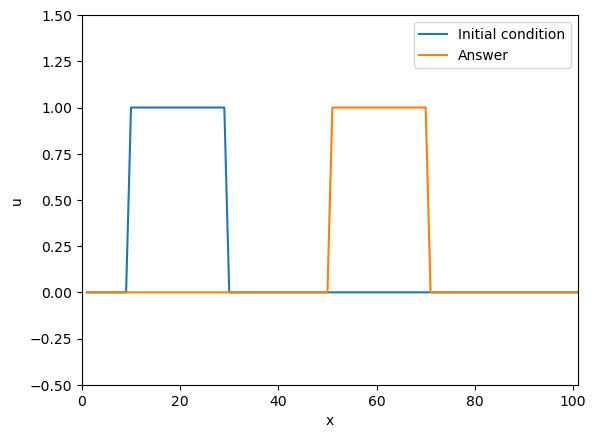

(-0.5, 1.5)

In [41]:
# plt.plot(x_array, u_array, label="Initial condition")
# plt.plot(x_array, exact_u_array, label="Answer")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u")
# plt.xlim(0, max(x_array))
# plt.ylim(-0.5,1.5)
using PyPlot
PyPlot.plot(x_array, u_array, label="Initial condition")
PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)

PyPlotのロードにちょっと時間がかかる。しかも初回インストール付きでだいぶ時間かかった。

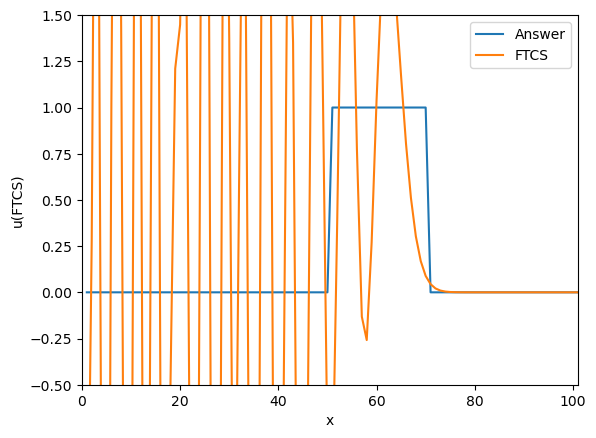

(-0.5, 1.5)

In [42]:
#u_ftcs = u_array.copy()
u_ftcs = copy(u_array)
# タイムステップを設定
#for n in range(Time_step):
for n in 1:Time_step
    #u_old = u_ftcs.copy()
    u_old = copy(u_ftcs)
    #u_ftcs[0] = u_old[0] - CFL / 2 * (u_old[1] - u_lower_boundary)
    u_ftcs[1] = u_old[1] - CFL / 2 * (u_old[2] - u_lower_boundary)
    #u_ftcs[-1] = u_old[-1] - CFL / 2 * (u_upper_boundary - u_old[-1])
    u_ftcs[end] = u_old[end] - CFL / 2 * (u_upper_boundary - u_old[end])
    
    #for j in range(1,Num_stencil_x-1, 1):
    for j in 2: Num_stencil_x-1
        u_ftcs[j] = u_old[j] - CFL / 2 * (u_old[j+1] - u_old[j-1])
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_ftcs, label="FTCS")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(FTCS)")
# plt.xlim(0, max(x_array))
# plt.ylim(-0.5,1.5)

PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_ftcs, label="FTCS")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(FTCS)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)


できたできた。ついでにΔｔを疑似的に小さくしてみる＝CFLの値をちょく/10してステップ数x10しておく

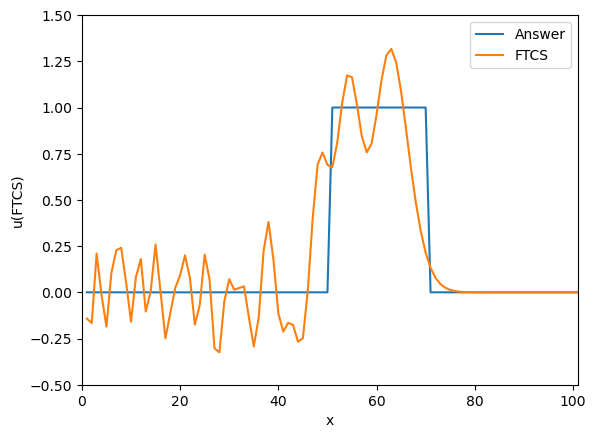

(-0.5, 1.5)

In [44]:
u_ftcs = copy(u_array)
# タイムステップを設定
for n in 1:Time_step*10
    u_old = copy(u_ftcs)
    u_ftcs[1] = u_old[1] - (CFL/10) / 2 * (u_old[2] - u_lower_boundary)
    u_ftcs[end] = u_old[end] - (CFL/10) / 2 * (u_upper_boundary - u_old[end])
    
    for j in 2: Num_stencil_x-1
        u_ftcs[j] = u_old[j] - (CFL/10) / 2 * (u_old[j+1] - u_old[j-1])
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_ftcs, label="FTCS")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(FTCS)")
# plt.xlim(0, max(x_array))
# plt.ylim(-0.5,1.5)

PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_ftcs, label="FTCS")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(FTCS)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)


しんどうましになった

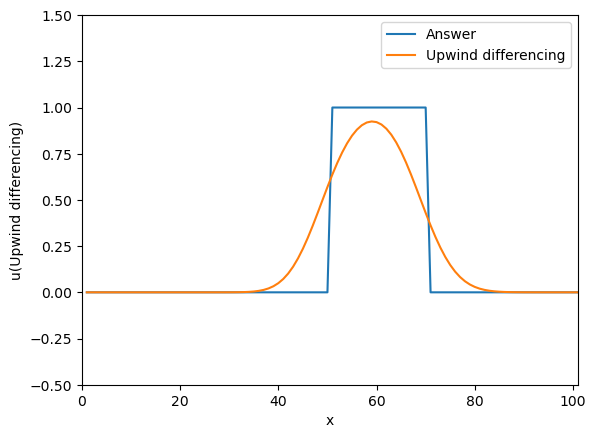

(-0.5, 1.5)

In [51]:
#u_upwind = u_array.copy()
u_upwind = copy(u_array)

# タイムステップを設定
#for n in range(Time_step):
for n in 1:Time_step
#     u_old = u_upwind.copy()
    u_old = copy(u_upwind)
#     u_upwind[0:1] = u_old[0] - CFL * (u_old[1] - u_lower_boundary)
    u_upwind[1:2] .= u_old[1] - CFL * (u_old[2] - u_lower_boundary)
#     for j in range(1,Num_stencil_x):
    for j in 2:Num_stencil_x-1
#         u_upwind[j:j+1] = u_old[j] - CFL * (u_old[j] - u_old[j-1])
        u_upwind[j:j+1] .= u_old[j] - CFL * (u_old[j] - u_old[j-1])
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_upwind, label="Upwind differencing")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(Upwind differencing)")
# plt.xlim(0, max(x_array))
# plt.ylim(-0.5,1.5)
PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_upwind, label="Upwind differencing")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(Upwind differencing)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)

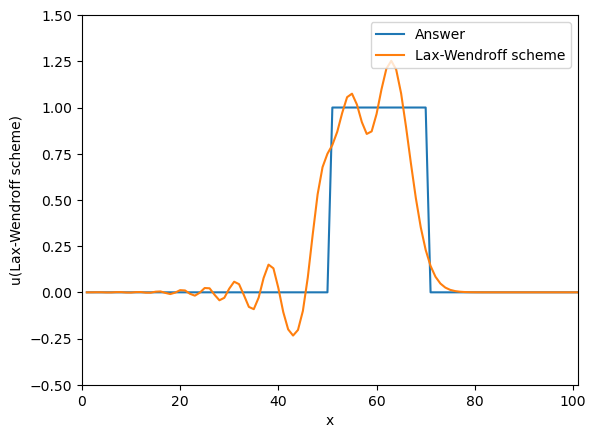

(-0.5, 1.5)

In [54]:
# u_lw= u_array.copy()        
u_lw= copy(u_array)

# タイムステップを設定
# for n in range(Time_step):
for n in 1:Time_step
#     u_old = u_lw.copy()
    u_old = copy(u_lw)
#     u_lw[0:1] = u_old[0] - CFL / 2 * (u_old[1] - u_lower_boundary) \
#                     + CFL**2 / 2 * (u_old[1] - 2 * u_old[0] + u_lower_boundary)
    u_lw[1:2] .= u_old[1] - CFL / 2 * (u_old[2] - u_lower_boundary) + CFL^2 / 2 * (u_old[2] - 2 * u_old[1] + u_lower_boundary)
#     u_lw[-1] = u_old[-1] - CFL / 2 * (u_upper_boundary - u_old[-1]) \
#                     + CFL**2 / 2 * (u_upper_boundary - 2 * u_old[-1] + u_old[-2])
    u_lw[end] = u_old[end] - CFL / 2 * (u_upper_boundary - u_old[end]) + CFL^2 / 2 * (u_upper_boundary - 2 * u_old[end] + u_old[end-1])
    
#     for j in range(1,Num_stencil_x-1, 1):
    for j in 2:Num_stencil_x-1
#         u_lw[j] = u_old[j] - CFL / 2 * (u_old[j+1] - u_old[j-1]) \
#                     + CFL**2 / 2 * (u_old[j+1] - 2 * u_old[j] + u_old[j-1])
        u_lw[j] = u_old[j] - CFL / 2 * (u_old[j+1] - u_old[j-1]) + CFL^2 / 2 * (u_old[j+1] - 2 * u_old[j] + u_old[j-1])
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_lw, label="Lax-Wendroff scheme")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(Lax-Wendroff scheme)")
# plt.xlim(0, max(x_array))
# plt.ylim(-0.5,1.5)
PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_lw, label="Lax-Wendroff scheme")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(Lax-Wendroff scheme)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)

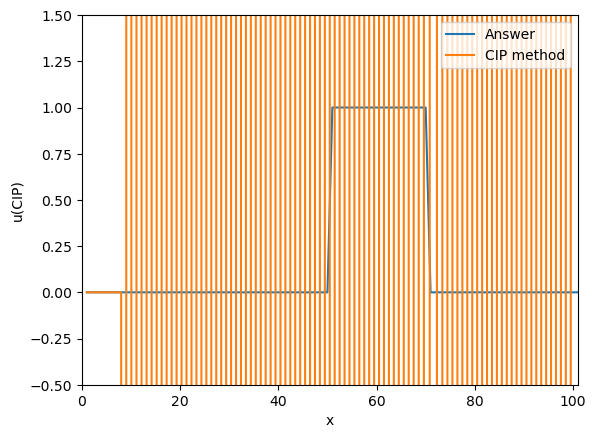

(-0.5, 1.5)

In [80]:
# u_cip= u_array.copy()
u_cip= copy(u_array)

# partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
partial_u_cip = ((vcat(u_cip[2:end], [u_upper_boundary]) .+ u_cip)./2 .- (vcat([u_lower_boundary],u_cip[1:end-1]) .+ u_cip)./2)./ Delta_x
##いいかきかたがわからない！

# 時間発展させる
# for n in range(Time_step):
for n in 1:Time_step
#     u_old = u_cip.copy()
#     partial_u_old = partial_u_cip.copy()
    u_old = copy(u_cip)
    partial_u_old = copy(partial_u_cip)
#     u_cip[0] = 0
#     partial_u_cip[0] = 0
    u_cip[1] = 0
    partial_u_cip[1] = 0

#     for j in range(1, Num_stencil_x):
    for j in 2 : Num_stencil_x-1
#         a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x**2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x**3
        a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x^2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x^3
#         b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x**2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x^2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        c = partial_u_old[j]
        d = u_old[j]
        xi = - C * Delta_t  # C > 0
#         u_cip[j:j+1] = a * xi**3 + b * xi**2 + c * xi + d
        u_cip[j:j+1] .= a * xi^3 + b * xi^2 + c * xi + d
#         partial_u_cip[j:j+1] = 3 * a * xi**2 + 2 * b * xi + c
        partial_u_cip[j:j+1] .= 3 * a * xi^2 + 2 * b * xi + c
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_cip, label="CIP method")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(CIP)")
# plt.xlim(0, max(x_array))
# # plt.ylim(-0.5,1.5)
PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_cip, label="CIP method")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(CIP)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)

あれ？

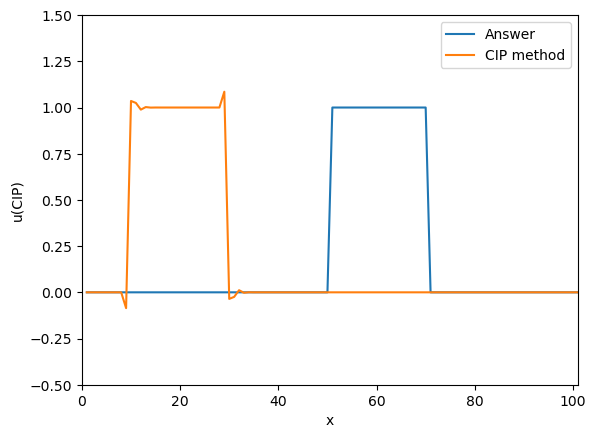

(-0.5, 1.5)

In [85]:
# u_cip= u_array.copy()
u_cip= copy(u_array)

# partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
partial_u_cip = ((vcat(u_cip[2:end], u_upper_boundary) .+ u_cip)./2 .- (vcat(u_lower_boundary, u_cip[1:end-1]) .+ u_cip)./2)./ Delta_x


# 時間発展させる
# for n in range(Time_step):
for n in 1:2
#     u_old = u_cip.copy()
#     partial_u_old = partial_u_cip.copy()
    u_old = copy(u_cip)
    partial_u_old = copy(partial_u_cip)
#     u_cip[0] = 0
#     partial_u_cip[0] = 0
    u_cip[1] = 0
    partial_u_cip[1] = 0

#     for j in range(1, Num_stencil_x):
    for j in 2 : Num_stencil_x-1
#         a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x**2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x**3
        a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x^2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x^3
#         b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x**2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x^2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        c = partial_u_old[j]
        d = u_old[j]
        xi = - C * Delta_t  # C > 0
#         u_cip[j:j+1] = a * xi**3 + b * xi**2 + c * xi + d
        u_cip[j:j+1] .= a * xi^3 + b * xi^2 + c * xi + d
#         partial_u_cip[j:j+1] = 3 * a * xi**2 + 2 * b * xi + c
        partial_u_cip[j:j+1] .= 3 * a * xi^2 + 2 * b * xi + c
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_cip, label="CIP method")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(CIP)")
# plt.xlim(0, max(x_array))
# # plt.ylim(-0.5,1.5)
PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_cip, label="CIP method")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(CIP)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)

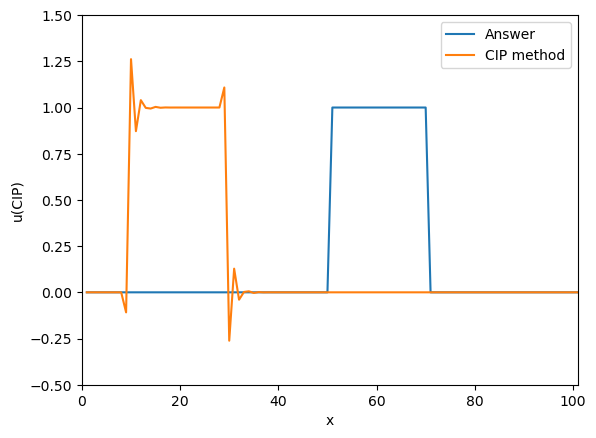

(-0.5, 1.5)

In [84]:
# u_cip= u_array.copy()
u_cip= copy(u_array)

# partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
partial_u_cip = ((vcat(u_cip[2:end], u_upper_boundary) .+ u_cip)./2 .- (vcat(u_lower_boundary, u_cip[1:end-1]) .+ u_cip)./2)./ Delta_x


# 時間発展させる
# for n in range(Time_step):
for n in 1:5
#     u_old = u_cip.copy()
#     partial_u_old = partial_u_cip.copy()
    u_old = copy(u_cip)
    partial_u_old = copy(partial_u_cip)
#     u_cip[0] = 0
#     partial_u_cip[0] = 0
    u_cip[1] = 0
    partial_u_cip[1] = 0

#     for j in range(1, Num_stencil_x):
    for j in 2 : Num_stencil_x-1
#         a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x**2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x**3
        a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x^2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x^3
#         b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x**2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x^2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        c = partial_u_old[j]
        d = u_old[j]
        xi = - C * Delta_t  # C > 0
#         u_cip[j:j+1] = a * xi**3 + b * xi**2 + c * xi + d
        u_cip[j:j+1] .= a * xi^3 + b * xi^2 + c * xi + d
#         partial_u_cip[j:j+1] = 3 * a * xi**2 + 2 * b * xi + c
        partial_u_cip[j:j+1] .= 3 * a * xi^2 + 2 * b * xi + c
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_cip, label="CIP method")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(CIP)")
# plt.xlim(0, max(x_array))
# # plt.ylim(-0.5,1.5)
PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_cip, label="CIP method")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(CIP)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)

forでずれてそう

In [86]:
u_cip= copy(u_array)
partial_u_cip = ((vcat(u_cip[2:end], u_upper_boundary) .+ u_cip)./2 .- (vcat(u_lower_boundary, u_cip[1:end-1]) .+ u_cip)./2)./ Delta_x

101-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.49504950495049505
 0.49504950495049505
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [89]:
for i in partial_u_cip
    print(i)
    print(",")
end

0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49504950495049505,0.49504950495049505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.49504950495049505,-0.49504950495049505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [93]:
for i in u_cip
    print(i)
    print(",")
end

0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

ここは大丈夫そう？0.5になってないのはちょっときになる

In [94]:
Delta_x

1.01

In [95]:
maximum(x_array)

101

おまえか！
最初からやりなおそう…。

In [96]:
# Creat square wave
Num_stencil_x = 101
#x_array = np.arange(Num_stencil_x)
x_array =Vector(1:Num_stencil_x-1) #修正
#u_array = np.where(((x_array >= 30) |(x_array < 10)), 0.0, 1.0)
u_array = [(if (i>=30) | (i < 10) 0.0 else 1.0 end) for i in x_array]

u_lower_boundary = 0.0
u_upper_boundary = 0.0
Time_step = 200

#Delta_x = max(x_array) / (Num_stencil_x-1)
Delta_x = maximum(x_array) / (Num_stencil_x-1)

C = 1
Delta_t = 0.2
CFL = C * Delta_t / Delta_x
total_movement = C * Delta_t * (Time_step+1)

#exact_u_array = np.where(((x_array >= 30 + total_movement) |(x_array < 10 + total_movement)), 0.0, 1.0)
exact_u_array = [(if (i>=30 + total_movement) | (i < 10 + total_movement) 0.0 else 1.0 end) for i in x_array]


100-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

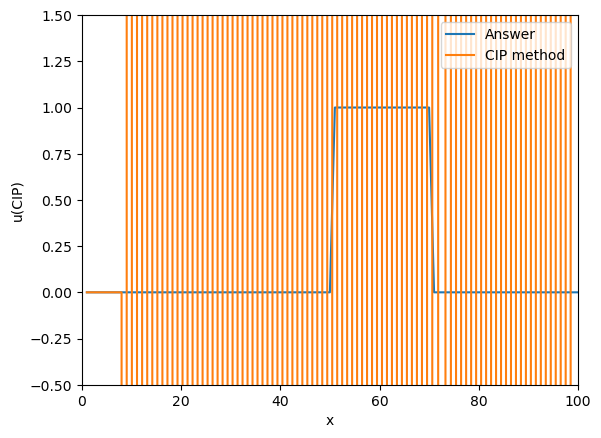

(-0.5, 1.5)

In [120]:
# u_cip= u_array.copy()
u_cip= copy(u_array)

# partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
partial_u_cip = ((vcat(u_cip[2:end], u_upper_boundary) .+ u_cip)./2 .- (vcat(u_lower_boundary, u_cip[1:end-1]) .+ u_cip)./2)./ Delta_x


# 時間発展させる
# for n in range(Time_step):
for n in 1:Time_step
#     u_old = u_cip.copy()
#     partial_u_old = partial_u_cip.copy()
    u_old = copy(u_cip)
    partial_u_old = copy(partial_u_cip)
#     u_cip[0] = 0
#     partial_u_cip[0] = 0
    u_cip[1] = 0
    partial_u_cip[1] = 0

#     for j in range(1, Num_stencil_x):
    for j in 2 : Num_stencil_x-2
#         a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x**2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x**3
        a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x^2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x^3
#         b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x**2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x^2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        c = partial_u_old[j]
        d = u_old[j]
        xi = - C * Delta_t  # C > 0
#         u_cip[j:j+1] = a * xi**3 + b * xi**2 + c * xi + d
        u_cip[j:j+1] .= a * xi^3 + b * xi^2 + c * xi + d
#         partial_u_cip[j:j+1] = 3 * a * xi**2 + 2 * b * xi + c
        partial_u_cip[j:j+1] .= 3 * a * xi^2 + 2 * b * xi + c
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_cip, label="CIP method")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(CIP)")
# plt.xlim(0, max(x_array))
# # plt.ylim(-0.5,1.5)
PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_cip, label="CIP method")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(CIP)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)


ちがう…っていうか、ずれてるよね？

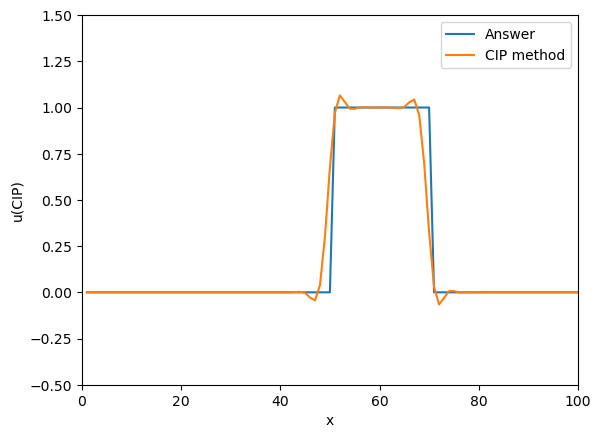

(-0.5, 1.5)

In [111]:
# u_cip= u_array.copy()
u_cip= copy(u_array)

# partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
partial_u_cip = ((vcat(u_cip[2:end], u_upper_boundary) .+ u_cip)./2 .- (vcat(u_lower_boundary, u_cip[1:end-1]) .+ u_cip)./2)./ Delta_x


# 時間発展させる
# for n in range(Time_step):
for n in 1:Time_step
#     u_old = u_cip.copy()
#     partial_u_old = partial_u_cip.copy()
    u_old = copy(u_cip)
    partial_u_old = copy(partial_u_cip)
#     u_cip[0] = 0
#     partial_u_cip[0] = 0
    u_cip[1] = 0
    partial_u_cip[1] = 0

#     for j in range(1, Num_stencil_x):
    for j in 2 : Num_stencil_x-2
#         a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x**2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x**3
        a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x^2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x^3
#         b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x**2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x^2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
        c = partial_u_old[j]
        d = u_old[j]
        xi = - C * Delta_t  # C > 0
#         u_cip[j:j+1] = a * xi**3 + b * xi**2 + c * xi + d
        u_cip[j] = a * xi^3 + b * xi^2 + c * xi + d ##おまえだ！
#         partial_u_cip[j:j+1] = 3 * a * xi**2 + 2 * b * xi + c
        partial_u_cip[j] = 3 * a * xi^2 + 2 * b * xi + c ##おまえだ！
    end
end

# plt.plot(x_array, exact_u_array, label="Answer")
# plt.plot(x_array, u_cip, label="CIP method")
# plt.legend(loc="upper right")
# plt.xlabel("x")
# plt.ylabel("u(CIP)")
# plt.xlim(0, max(x_array))
# # plt.ylim(-0.5,1.5)
PyPlot.plot(x_array, exact_u_array, label="Answer")
PyPlot.plot(x_array, u_cip, label="CIP method")
PyPlot.legend(loc="upper right")
PyPlot.xlabel("x")
PyPlot.ylabel("u(CIP)")
PyPlot.xlim(0, maximum(x_array))
PyPlot.ylim(-0.5,1.5)


In [116]:
#https://twitter.com/genkuroki/status/948582344696373249

using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


In [118]:
function hoge()

    # u_cip= u_array.copy()
    u_cip= copy(u_array)

    # partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
    partial_u_cip = ((vcat(u_cip[2:end], u_upper_boundary) .+ u_cip)./2 .- (vcat(u_lower_boundary, u_cip[1:end-1]) .+ u_cip)./2)./ Delta_x


    # 時間発展させる
    # for n in range(Time_step):
    for n in 1:Time_step
    #     u_old = u_cip.copy()
    #     partial_u_old = partial_u_cip.copy()
        u_old = copy(u_cip)
        partial_u_old = copy(partial_u_cip)
    #     u_cip[0] = 0
    #     partial_u_cip[0] = 0
        u_cip[1] = 0
        partial_u_cip[1] = 0

    #     for j in range(1, Num_stencil_x):
        for j in 2 : Num_stencil_x-2
    #         a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x**2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x**3
            a = (partial_u_old[j] + partial_u_old[j-1]) / Delta_x^2 - 2.0 * (u_old[j] - u_old[j-1]) / Delta_x^3
    #         b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x**2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
            b = 3 * (u_old[j-1] - u_cip[j]) / Delta_x^2 + (2.0*partial_u_old[j] + partial_u_old[j-1]) / Delta_x
            c = partial_u_old[j]
            d = u_old[j]
            xi = - C * Delta_t  # C > 0
    #         u_cip[j:j+1] = a * xi**3 + b * xi**2 + c * xi + d
            u_cip[j] = a * xi^3 + b * xi^2 + c * xi + d ##おまえだ！
    #         partial_u_cip[j:j+1] = 3 * a * xi**2 + 2 * b * xi + c
            partial_u_cip[j] = 3 * a * xi^2 + 2 * b * xi + c ##おまえだ！
        end
    end

    # plt.plot(x_array, exact_u_array, label="Answer")
    # plt.plot(x_array, u_cip, label="CIP method")
    # plt.legend(loc="upper right")
    # plt.xlabel("x")
    # plt.ylabel("u(CIP)")
    # plt.xlim(0, max(x_array))
    # # plt.ylim(-0.5,1.5)
    PyPlot.plot(x_array, exact_u_array, label="Answer")
    PyPlot.plot(x_array, u_cip, label="CIP method")
    PyPlot.legend(loc="upper right")
    PyPlot.xlabel("x")
    PyPlot.ylabel("u(CIP)")
    PyPlot.xlim(0, maximum(x_array))
    PyPlot.ylim(-0.5,1.5)
end


hoge (generic function with 1 method)

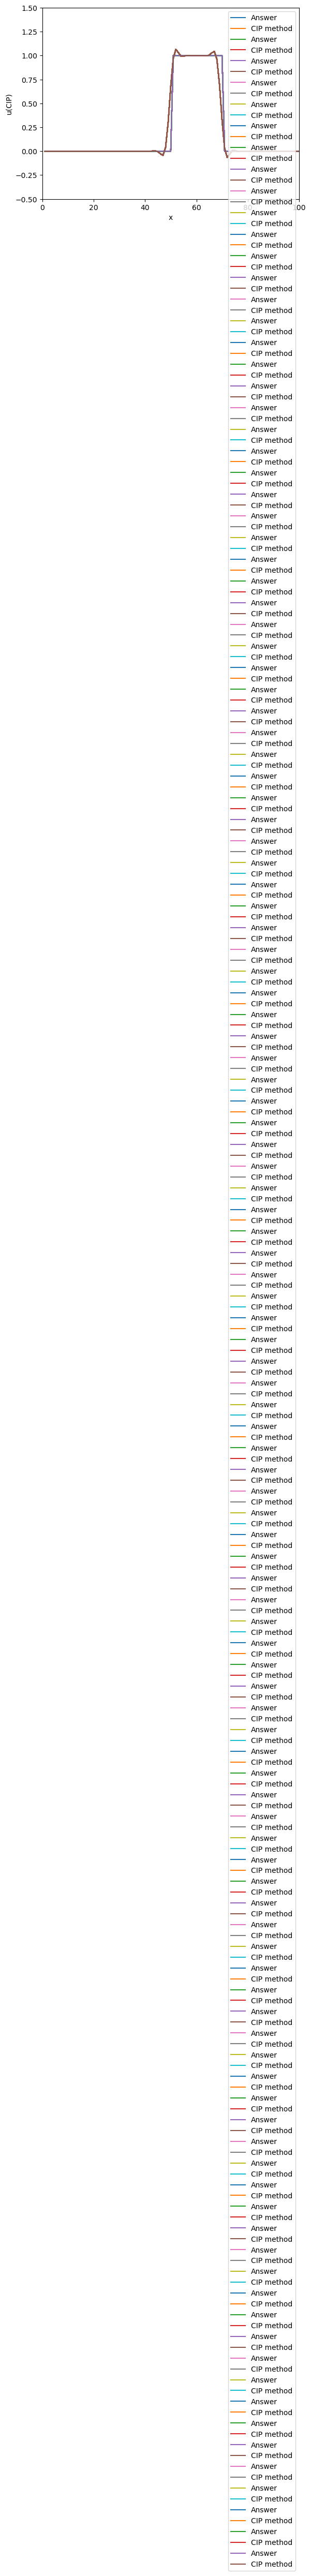

BenchmarkTools.Trial: 
  memory estimate:  12.63 MiB
  allocs estimate:  785098
  --------------
  minimum time:     87.012 ms (0.00% GC)
  median time:      104.454 ms (0.00% GC)
  mean time:        136.777 ms (0.34% GC)
  maximum time:     358.496 ms (0.00% GC)
  --------------
  samples:          38
  evals/sample:     1

In [119]:
@benchmark hoge()


まったく意味ないけどベンチマークしてみた。  
全く意味ないのは知ってる。pythonは%%timeでセルを測って132msでまあ同じくらい。  
どう考えても計算に時間がかかってなくてpyplotの処理速度な気がする
